In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_wine # Read more about IRIS Dataset here https://www.kaggle.com/code/kostasmar/exploring-the-iris-data-set-scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
iris = load_wine() 
x = iris.data
y = iris.target
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
import tensorflow as tf

In [31]:
ytrain2 = []
for e in ytrain:
    for i in range(3):
        if e[i] != 0:
            ytrain2.append(i)

ytest2 = []
for e in ytest:
    for i in range(3):
        if e[i] != 0:
            ytest2.append(i)

In [32]:
ytrain2 = np.array(ytrain2)
ytrain2

array([2, 2, 1, 2, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0,
       1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1,
       1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1,
       0, 1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 1, 0, 1, 1])

In [33]:
ytest2 = np.array(ytest2)
ytest2

array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0])

In [34]:
ytrain, ytest = ytrain2, ytest2

In [35]:
def create_model(hp):
    
    num_hidden_layers = 1
    num_units = 8
    dropout_rate = 0.2
    learning_rate = 0.01
    
    if hp:
        num_hidden_layers = hp.Choice('num_hidden_layers',values=[1,2,3])
        num_units = hp.Choice('num_units',values=[8,16,32])
        dropout_rate = hp.Float('dropout_rate', min_value=0.1,max_value=0.5)
        learning_rate = hp.Float('learning_rate', min_value=0.0001,max_value=0.01)

    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(xtrain.shape[1],)))
    model.add(tf.keras.layers.Input(shape=xtrain.shape[1]))
    
    for _ in range(0,num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation='relu', use_bias=True))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(max(ytrain)+1,activation='softmax'))
    
    model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
    
    return model


In [36]:
create_model(None).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 112       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 batch_normalization_4 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 3)                 27        
                                                                 
Total params: 171
Trainable params: 155
Non-trainable params: 16
_________________________________________________________________


In [37]:
import kerastuner

# Implement Question 2 here

class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self,trial,*args,**kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128, step=32)
        super(CustomTuner,self).run_trial(trial,*args,**kwargs)
        
        model = self.hypermodel.build(trial.hyperparameters)
        metrics = model.evaluate(xtest, ytest)
        
        return metrics


In [38]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=2,
    directory='my_tune_logs',
    project_name='spotify_genre',
    overwrite=True
)

In [39]:
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True) 
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True) 

In [40]:
tuner.search(
    xtrain, ytrain,
    validation_data=(xtest,ytest),
    epochs=2,verbose=True,
    callbacks=[early_stopping1, early_stopping2]
)

Trial 2 Complete [00h 00m 03s]
val_accuracy: 26.698587842285633

Best val_accuracy So Far: 33.18465084582567
Total elapsed time: 00h 00m 07s


In [19]:
tuner.results_summary(5)

Results summary
Results in my_tune_logs/spotify_genre
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_hidden_layers: 3
num_units: 16
dropout_rate: 0.3485671827646833
learning_rate: 0.004654406254382229
batch_size: 32
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/tmp/ipykernel_32/3596225446.py", line 8, in run_trial
    super(CustomTuner,self).run_trial(trial,*args,**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/pyt

In [41]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [42]:
_ = model.fit(
    xtrain, ytrain,
    validation_data = (xtest, ytest),
    epochs=20,batch_size=96,
    callbacks=[early_stopping1, early_stopping2]
)

Epoch 1/20
2/2 [==============================] - 2s 260ms/step - loss: 1.1248 - accuracy: 0.4577 - val_loss: 6.5699 - val_accuracy: 0.3889
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.9688 - accuracy: 0.5986 - val_loss: 6.8859 - val_accuracy: 0.3889
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 1.0112 - accuracy: 0.5563 - val_loss: 6.9307 - val_accuracy: 0.3889
Epoch 4/20
2/2 [==============================] - 0s 36ms/step - loss: 0.9143 - accuracy: 0.5563 - val_loss: 6.7681 - val_accuracy: 0.3889
Epoch 5/20
2/2 [==============================] - 0s 39ms/step - loss: 0.9091 - accuracy: 0.5704 - val_loss: 6.4843 - val_accuracy: 0.3889
Epoch 6/20
2/2 [==============================] - 0s 38ms/step - loss: 0.8087 - accuracy: 0.6197 - val_loss: 5.9932 - val_accuracy: 0.3889
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.7167 - accuracy: 0.6408 - val_loss: 5.6297 - val_accuracy: 0.3889
Epoch 8/20
2/2 [==========

In [43]:
print(model.evaluate(xtrain, ytrain)) 
print(model.evaluate(xtest, ytest))

5/5 [==============================] - 0s 3ms/step - loss: 7.6301 - accuracy: 0.3169
[7.630101203918457, 0.31690141558647156]
2/2 [==============================] - 0s 7ms/step - loss: 6.5699 - accuracy: 0.3889
[6.569916725158691, 0.3888888955116272]


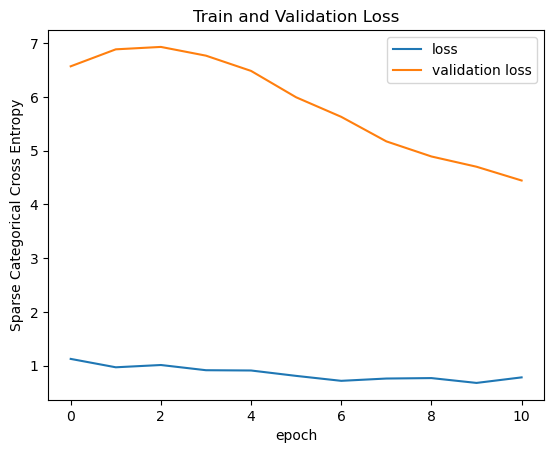

In [44]:
# Implement Question 3 here

import matplotlib.pyplot as plt

plt.plot(_.history["loss"]) 
plt.plot(_.history["val_loss"]) 
plt.legend(["loss", "validation loss"], loc ="upper right")
plt.title("Train and Validation Loss")
plt.xlabel("epoch") 
plt.ylabel("Sparse Categorical Cross Entropy") 
plt.show()

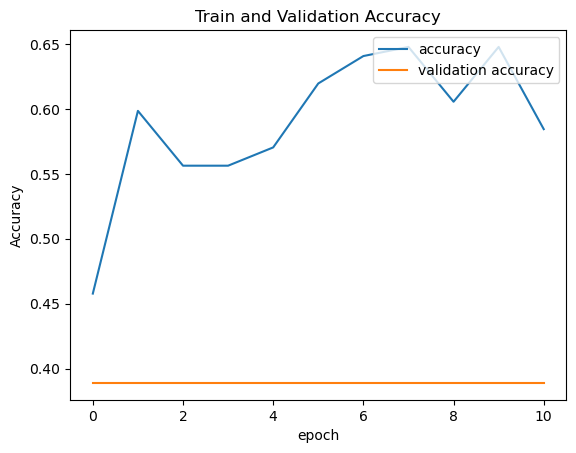

In [45]:
plt.plot(_.history["accuracy"])
plt.plot(_.history["val_accuracy"])
plt.legend(["accuracy", "validation accuracy"], loc ="upper right") 
plt.title("Train and Validation Accuracy") 
plt.xlabel("epoch") 
plt.ylabel("Accuracy") 
plt.show()

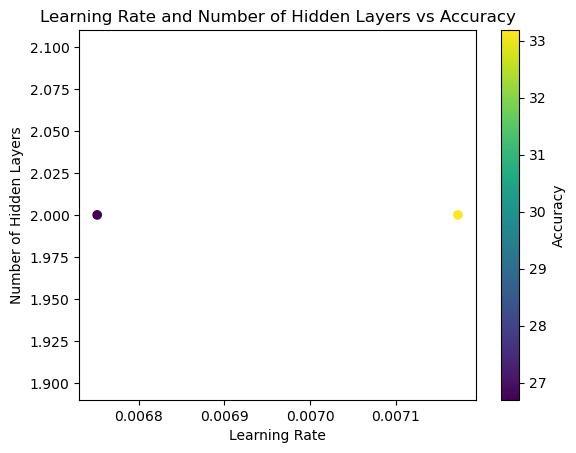

In [46]:
import matplotlib.pyplot as plt

learning_rates = []
num_hidden_layers = []
accuracies = []

for trial in tuner.oracle.get_best_trials(num_trials=10):
    hyperparameters = trial.hyperparameters.values
    learning_rates.append(hyperparameters['learning_rate'])
    num_hidden_layers.append(hyperparameters['num_hidden_layers'])
    accuracies.append(trial.metrics.get_best_value('val_accuracy'))

    
plt.scatter(learning_rates, num_hidden_layers, c=accuracies, cmap='viridis')
plt.colorbar(label='Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Hidden Layers')
plt.title('Learning Rate and Number of Hidden Layers vs Accuracy')
plt.show()
